## Conjugate Gradient Analysis Notebook

This notebook analyses the behavior of Conjugate Gradient computed solutions to the equation $f_{\alpha, r} = (P_r K P_r + \alpha)^{-1} P_r B 1$
without added noise. First, we initialize the problem.

In [1]:
import sys

sys.path.append("../")
import numpy as np
import src.ITRC
import src.simulation as simulation

# Parameters of the forward problem
L = 2.5
n_x = 200
dt = 0.01
solver_scale = 5  # The denser forward problem mesh size is scaled using this
T = 2.5

# Parameters of the inverse problem
alpha_vol = 10 ** (-6)  # Regularization parameter
CG_maxiter = 20

# Simulate Lambda
c = lambda x: 1
Lambda, dense_t_mesh = simulation.simulate_Lambda(
    c=c, dt=dt, T=T, L=L, solver_scale=solver_scale, cmax=1
)

# Create ITRC object
ITRC = src.ITRC.ITRC(L, n_x, T, dense_t_mesh[0::solver_scale], Lambda)

In [2]:
def create_LHS_arr(ITRC, alpha_vol, r_ind):
    LHS_op, RHS = ITRC.construct_operators(alpha_vol=alpha_vol, r_ind=r_ind)
    vecs = []
    for v in np.eye(len(ITRC.t_mesh)):
        vecs.append(LHS_op @ v)
    LHS_arr = np.array(vecs).T
    return LHS_arr


test_alphas = [10**k for k in range(-8, -1)]

arrs = dict()
for alpha_vol in test_alphas:
    arrs[alpha_vol] = create_LHS_arr(ITRC, alpha_vol, r_ind=len(ITRC.r_mesh) - 2)

We look at the eigenvalues of $K$ and $P_r K P_r + \alpha_{\text{Vol}}$. Conjugate gradient expects the input to be positive definite, meaning that the smallest eigenvalue should be positive. We will observe that this is not always the case due to approximation errors.

In [3]:
K = ITRC.matrix_K(Lambda=ITRC.Lambda)
np.linalg.eigvals(K).min()

np.float64(-1.901532582503565e-07)

In [4]:
for alpha_vol in arrs.keys():
    cond = np.linalg.cond(arrs[alpha_vol])
    min_eig = np.linalg.eigvals(arrs[alpha_vol]).min()
    print(f"{alpha_vol = }, {cond = }, {min_eig}")

alpha_vol = 1e-08, cond = np.float64(8653094271.040073), -1.8015325824111065e-07
alpha_vol = 1e-07, cond = np.float64(2904352843.8501744), -9.015325825578286e-08
alpha_vol = 1e-06, cond = np.float64(10252048.683097389), 8.098467417493067e-07
alpha_vol = 1e-05, cond = np.float64(308551.13134661416), 9.809846741748415e-06
alpha_vol = 0.0001, cond = np.float64(25990.8239866978), 9.980984674174045e-05
alpha_vol = 0.001, cond = np.float64(2559.118858402526), 0.0009998098467417413
alpha_vol = 0.01, cond = np.float64(255.75275285880522), 0.00999980984674177


As seen in the above computations, small errors in the calculation of $K$ (see `operator_testing.ipynb`) make it so that the matrix of $P_r K P_r + \alpha_{\text{Vol}}$ is not positive definite if $\alpha_{\text{Vol}}$ is very small. However, the matrix is positive definite if $\alpha_{\text{Vol}} \geq 10^{-6}$. Next, we look at how the norm of the matrix changes with $\alpha_{\text{Vol}}$.

In [5]:
for alpha_vol in arrs.keys():
    norm = np.linalg.norm(arrs[alpha_vol])
    print(f"{alpha_vol = }, {norm = }")

alpha_vol = 1e-08, norm = np.float64(2.554066267693975)
alpha_vol = 1e-07, norm = np.float64(2.55406637759155)
alpha_vol = 1e-06, norm = np.float64(2.5540674766544313)
alpha_vol = 1e-05, norm = np.float64(2.554078475996016)
alpha_vol = 0.0001, norm = np.float64(2.554189340647661)
alpha_vol = 0.001, norm = np.float64(2.555385067303582)
alpha_vol = 0.01, norm = np.float64(2.575990777428781)


We plot boundary sources $f_{\alpha,r}$ for a fixed $r$ with varying $\alpha$:

Error in CG result = 0.0003490762473208342
exit_code = 20
Error in CG result = 0.0002956072222637385
exit_code = 20
Error in CG result = 8.823588759643286e-07
exit_code = 20
Error in CG result = 4.589016844303018e-08
exit_code = 0


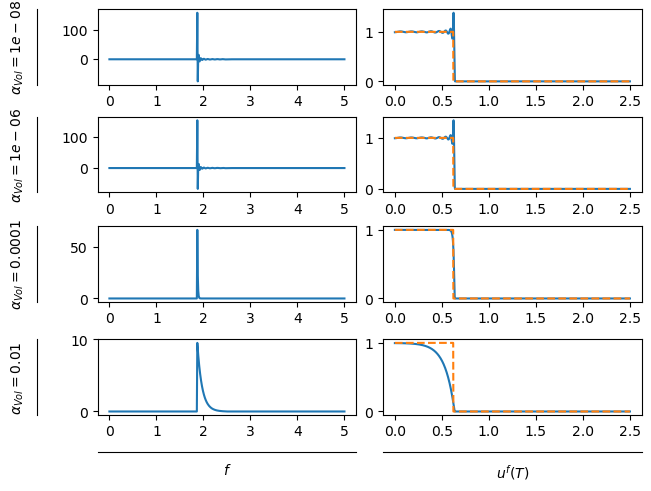

In [6]:
import plot_tools


def a(x):
    return c(x) ** 2


test_alphas = [10**k for k in range(-8, 0, 2)]
test_r_ind = len(ITRC.r_mesh) // 4


plot_tools.f_alpha_r_plot(
    ITRC=ITRC,
    alphas=test_alphas,
    r_ind=test_r_ind,
    a=a,
    cmax=1,
    atol=1e-8,
    rtol=1e-7,
    maxiter=CG_maxiter,
    method="CG",
)

Next, we calculate boundary term errors as a function of mesh size:

In [7]:
import scipy.interpolate

dt_arr = np.logspace(-4, -11, num=7, base=2)
dt_alphas = np.array([10**k for k in [-8, -6, -4, -2]])
errs = np.zeros((dt_arr.size, dt_alphas.size))
for i, dt in enumerate(dt_arr):
    for j, alpha_vol in enumerate(dt_alphas):

        # Simulate Lambda
        Lambda, dense_t_mesh = simulation.simulate_Lambda(
            c=c, dt=dt, T=T, L=L, solver_scale=solver_scale, cmax=1
        )

        # Create ITRC object, compute volume
        new_ITRC = src.ITRC.ITRC(L, n_x, T, dense_t_mesh[0::solver_scale], Lambda)
        r_ind = len(new_ITRC.r_mesh) // 2
        res, exit_code = new_ITRC.regularized_f_CG(
            r_ind=r_ind, alpha_vol=alpha_vol, atol=1e-8, rtol=1e-7, maxiter=CG_maxiter
        )

        # Compute solution
        minus_res_spl = scipy.interpolate.CubicHermiteSpline(
            new_ITRC.t_mesh, -res, dydx=np.zeros(new_ITRC.t_mesh.shape)
        )
        r = new_ITRC.r_mesh[r_ind]
        u, ts, xs = simulation.solver(
            (1 / solver_scale) * new_ITRC.dt,
            new_ITRC.T,
            h0=minus_res_spl,
            L=new_ITRC.L,
            a=a,
            cmax=1,
        )

        # Indicator function
        max_ind = len(ts) - 1
        indicator_arr = xs <= new_ITRC.r_mesh[r_ind]

        # Relative L^2 error
        err = np.linalg.norm(u - indicator_arr) / np.linalg.norm(indicator_arr)
        errs[i, j] = err
    print(f"{i = }, {dt = :.2E}, {errs[i, :] = }")

i = 0, dt = 6.25E-02, errs[i, :] = array([0.35977281, 0.35597034, 0.26778477, 0.12596284])
i = 1, dt = 2.78E-02, errs[i, :] = array([0.19730719, 0.19587177, 0.14190392, 0.14006994])
i = 2, dt = 1.24E-02, errs[i, :] = array([0.1097388 , 0.10853692, 0.06625659, 0.16884248])
i = 3, dt = 5.52E-03, errs[i, :] = array([0.05663272, 0.05568855, 0.03930311, 0.18409288])
i = 4, dt = 2.46E-03, errs[i, :] = array([0.03463589, 0.03460578, 0.05757838, 0.19801834])
i = 5, dt = 1.10E-03, errs[i, :] = array([0.03023742, 0.03014451, 0.05383413, 0.19670844])
i = 6, dt = 4.88E-04, errs[i, :] = array([0.03621237, 0.03621528, 0.0591571 , 0.19863   ])


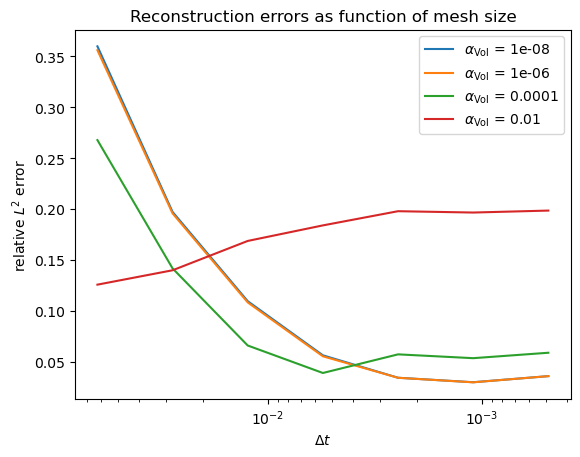

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
for j in range(dt_alphas.size):
    ax.semilogx(
        dt_arr, errs[:, j], label=rf"$\alpha_{{\text{{Vol}}}}$ = {dt_alphas[j]}"
    )

ax.set_title("Reconstruction errors as function of mesh size")
ax.set_xlabel(r"$\Delta t$")
ax.set_ylabel(r"relative $L^2$ error")
ax.legend()
ax.invert_xaxis()

Finally, we plot boundary sources for a fixed $\alpha$ with varying $r$:

Error in CG result = 1.7486012637846216e-18
exit_code = 0
Error in CG result = 5.497124291764521e-06
exit_code = 0
Error in CG result = 8.208298690193239e-06
exit_code = 0
Error in CG result = 1.6703570894005537e-05
exit_code = 0
Error in CG result = 9.439469244476584e-06
exit_code = 0
Error in CG result = 0.024741852003682396
exit_code = 20


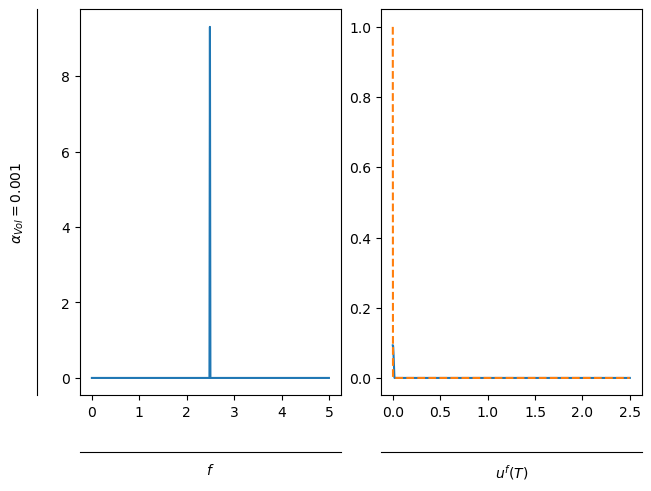

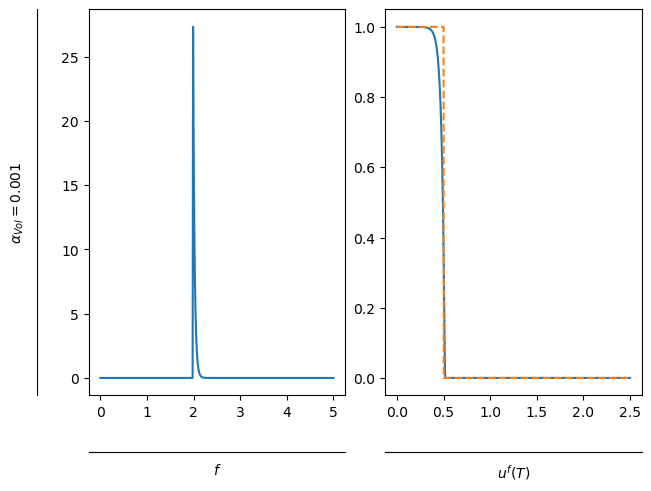

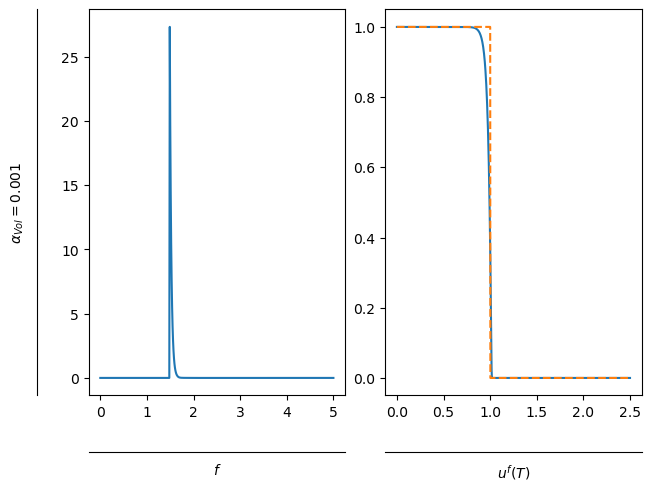

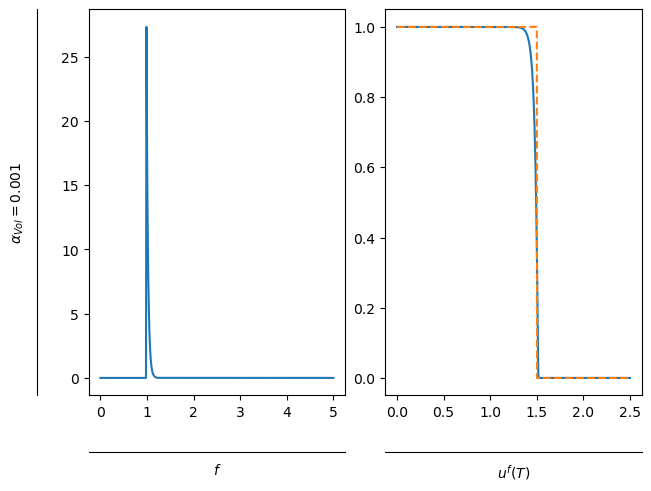

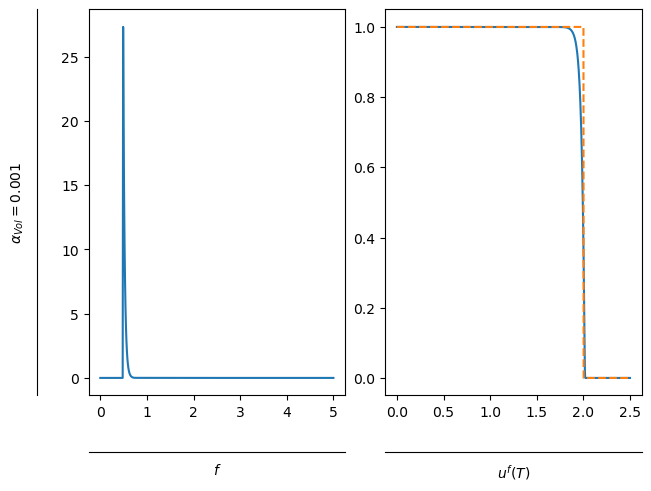

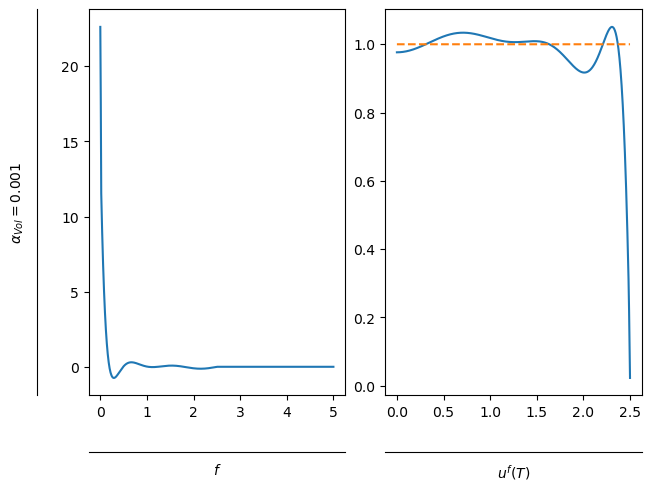

In [9]:
r_len = len(ITRC.r_mesh)

for r in range(0, r_len, r_len // 5):
    delta_arr = np.zeros(ITRC.t_mesh.shape)
    delta_arr[len(delta_arr) // 2 + 1 - (r)] = 1
    plot_tools.f_alpha_r_plot(
        ITRC=ITRC,
        x0=delta_arr / (1 * ITRC.dt),
        alphas=[1e-3],
        r_ind=r,
        a=a,
        cmax=1,
        atol=1e-6,
        rtol=1e-5,
        maxiter=CG_maxiter,
        method="CG",
    )

From these plots, it is clear that the boundary source $f$ has erratic behavior when $r$ is close to $T$. Exactly what causes this behavior
is unfortunately not clear. It is possible that this is related to the poor quality of reconstructions near $x=L$ in `variable_wave_speed.ipynb`.